Dependencies | Version
--- | ---
SatPy | 0.9.3
PyResample | 1.10.1
PySpectral | 0.8.2
Trollimage | 1.5.7
PyKdtree | 1.3.1
XArray | 0.10
Dask | 0.18.2
ImageIO | 2.3.0
ffmpeg | 3.4


# GOES-16 ABI - True Color Animation - Hurricane Florence



This example shows how to take multiple time steps of ABI data and combine them in to a single mp4 movie file as an animation. The example uses 100 frames of mesoscale images from the GOES-16 ABI instrument on September 11th, 2018 from 1300Z to 1440Z with one image every minute. The "%%time" magic command is used in jupyter notebook to time the entire cell's execution. This example took about 8 minutes and 30 seconds on a 2015 macbook using 8 dask threaded workers.

The movie produced has been hosted on twitter: https://twitter.com/PyTrollOrg/status/1039555399433834497

Full resolution video: https://www.ssec.wisc.edu/~davidh/satpy/true_color_20180911_130021.mp4

The frames in the movie are 500m resolution true color images with solar zenith and rayleigh scattering corrections applied. A ratio sharpening technique was also used to bring out more detail from the lower resolution input bands. All of this is pre-configured for the ABI 'true_color' composite in satpy and is done from python.

In [22]:
import os
from satpy import Scene, DatasetID
import glob
from satpy.multiscene import MultiScene
from satpy.writers import get_enhanced_image

import matplotlib.pyplot as plt
from matplotlib import patheffects

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime

In [ ]:
from satpy import available_readers
available_readers()

In [27]:
def get_current_julian(Year,Month,Day):
    # Set the date you want to convert
    dt = datetime(Year,Month,Day)
    #dt = datetime.utcnow()

    # Start of year for reference
    d0 = datetime(Year, 1, 1)

    # Find the difference and add one to get the day number of the calander year
    delta = dt - d0
    Julian_Day = delta.days+1
    if Julian_Day < 100:
        Julian_Day = "0"+str(Julian_Day)
        if int(Julian_Day) < 10:
            Julian_Day = "0"+str(Julian_Day)

    Year = str('{0:%Y}'.format(dt))
    Month = str('{0:%m}'.format(dt))
    Day = str('{0:%d}'.format(dt))
    Hour = str('{0:%H}'.format(dt))
    Minute = str('{0:%m}'.format(dt))

    #'{0:%Y}'.format(dt)+"-"+'{0:%m}'.format(dt)+"-"+'{0:%d}'.format(dt)+"-"+'{0:%H}'.format(dt)
    print("date: ",Year+"-"+Month+"-"+Day)

    # Julian day (Day)
    print("Julian number: ",Julian_Day)
    return Year,Month,Day,Julian_Day

In [28]:
Year,Month,Day,Julian_Day = get_current_julian(2019,4,19)

date:  2019-04-19
Julian number:  109


In [30]:
Hour = 15

In [32]:
GOES_sample_path = "/Users/chowdahead/Downloads/GOES_Data/Dust/"

In [39]:
! rclone --include "OR_ABI-L1b-RadC-M6C13*.nc" copy Public-AWS:noaa-goes16/ABI-L1b-RadC/{Year}/{Julian_Day}/{Hour}/ \
    {GOES_sample_path}

Error: unknown command "OR_ABI-L1b-RadC-M6C14*.nc" for "rclone"
Run 'rclone --help' for usage.
2020/05/08 13:42:35 Fatal error: unknown command "OR_ABI-L1b-RadC-M6C14*.nc" for "rclone"


In [36]:
os.chdir(GOES_sample_path)

In [38]:
ls

OR_ABI-L1b-RadC-M6C11_G16_s20191091501194_e20191091503567_c20191091504027.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091506194_e20191091508567_c20191091509016.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091511194_e20191091513567_c20191091514016.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091516194_e20191091518567_c20191091519017.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091521194_e20191091523567_c20191091524016.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091526194_e20191091528567_c20191091529015.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091531194_e20191091533567_c20191091534028.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091536194_e20191091538567_c20191091539017.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091541194_e20191091543567_c20191091544016.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091546194_e20191091548567_c20191091549017.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091551194_e20191091553567_c20191091554017.nc
OR_ABI-L1b-RadC-M6C11_G16_s20191091556194_e20191091558567_c20191091559015.nc
OR_ABI-L1b-RadC-M6C11_G16_s20201280021110_e20201280023482_c20201280023567.nc

In [ ]:
glob.glob("/Users/chowdahead/Downloads/OR_ABI*.nc")

In [ ]:
BASE_DIR = '/Users/chowdahead/Downloads/GOES_Data/True_Color/'

In [ ]:

all_filenames = [glob.glob(fn.replace('C01', 'C0[123]*')[:len(BASE_DIR) + 50] + '*.nc') for fn in sorted(glob.glob(os.path.join(BASE_DIR, 'OR*-Rad*C01*.nc')))]
print(all_filenames)
scenes = [Scene(reader='abi_l1b', filenames=filenames) for filenames in all_filenames]
print("Number of Scenes: ", len(scenes))

mscn = MultiScene(scenes)
mscn.load(['true_color'])


#mscn.show('true_color')

new_mscn = mscn.resample(resampler='native')
new_mscn.save_animation(BASE_DIR+'/{name}_{start_time:%Y%m%d_%H%M%S}.mp4', fps=5)


In [ ]:
%%time

scn = Scene(reader='abi_l1b', filenames=glob.glob('/Users/chowdahead/Downloads/*ABI-L1b*.nc'))

scn.load(['true_color'])
 
new_scn = scn.resample(scn.min_area(), resampler='native')
new_scn.save_dataset('true_color', filename='true_color'+'.png')


In [ ]:
new_scn.show('true_color')

In [ ]:
%%time

scn = Scene(reader='abi_l1b', filenames=glob.glob('/Users/chowdahead/Downloads/GOES_Data/Dust/*ABI-L1b*.nc'))

scn.load(['dust'])
 
new_scn = scn.resample(scn.min_area(), resampler='native')
#new_scn.save_dataset('dust', filename='dust'+'.png')


In [ ]:
var = get_enhanced_image(new_scn['dust']).data
# Get true color data to use later and reorder the dimensions so matplotlib can use the image
# Sadly, this operation is not lazy (bad performance) in xarray at the time of writing
var = var.transpose('y', 'x', 'bands')

In [ ]:
new_scn['dust']

In [ ]:
new_scn['dust'].orbital_slot

In [ ]:
new_scn['dust'].mode

In [ ]:
new_scn['dust'].standard_name.capitalize()

In [ ]:
title = new_scn['dust'].orbital_slot
title2 = new_scn['dust'].standard_name.capitalize()+"-"+new_scn['dust'].mode

In [ ]:
title2

In [ ]:
"{0:%d-%B-%Y %H%MZ}".format(new_scn['dust'].start_time)

In [ ]:
fig = plt.figure(figsize=(20, 10), dpi=200)
abi_crs = var.attrs['area'].to_cartopy_crs()
ax = fig.add_subplot(1, 1, 1, projection=abi_crs)

ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='w')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='w')
#ax.set_extent([-85, -69, 27, 38], crs=ccrs.PlateCarree())

ax.imshow(var.data, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper')

text_time = ax.text(.995, 0.01, 
        "{0:%d-%B-%Y %H%MZ}".format(new_scn['dust'].start_time),
        horizontalalignment='right', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold')

text_time2 = ax.text(0.005, 0.01, 
        title+"\n"+title2,
        horizontalalignment='left', transform=ax.transAxes,
        color='white', fontsize=20, weight='bold')

outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
text_time.set_path_effects(outline_effect)
text_time2.set_path_effects(outline_effect)

plt.savefig("/Users/chowdahead/Desktop/GOES_rgb_dust.png",bbox_inches="tight")

In [ ]:
new_scn.show('dust')

In [ ]:
scn = Scene(reader='abi_l1b', filenames=glob.glob('/Users/chowdahead/Downloads/GOES_Data/Airmass/*ABI-L1b*.nc'))
scn.load(['airmass'])
 
ds_id = DatasetID(name="airmass")
#scn.load(["C01"])

new_scn = scn.resample(scn.min_area(), resampler='native')
scn.save_dataset('airmass', filename='airmass'+'.png')

In [ ]:
"{0:%Y-%m-%d %H%MZ}".format(new_scn['airmass'].start_time)

In [ ]:
var = get_enhanced_image(new_scn['airmass']).data
# Get true color data to use later and reorder the dimensions so matplotlib can use the image
# Sadly, this operation is not lazy (bad performance) in xarray at the time of writing
var = var.transpose('y', 'x', 'bands')

In [ ]:
fig = plt.figure(figsize=(20, 10), dpi=200)
abi_crs = var.attrs['area'].to_cartopy_crs()
ax = fig.add_subplot(1, 1, 1, projection=abi_crs)

ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='w')
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='w')
#ax.set_extent([-85, -69, 27, 38], crs=ccrs.PlateCarree())

ax.imshow(var.data, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper')

plt.savefig("/Users/chowdahead/Desktop/GOES_rgb_airmass.png",bbox_inches="tight")

In [ ]:
scn.show('airmass')

In [ ]:
scn.available_composite_names()

In [ ]:
pwd

In [ ]:
rgb_prod = {"airmass":{},
            "dust":{}
    
}

In [6]:
filenames = glob.glob('/Users/chowdahead/Downloads/GOES_Data/True_Color/*ABI-L1b*.nc')
product = "true_color"

In [9]:
filenames = glob.glob('/Users/chowdahead/Downloads/GOES_Data/Dust/*ABI-L1b*.nc')
product = "dust"

In [ ]:
filenames = glob.glob('/Users/chowdahead/Downloads/GOES_Data/Airmass/*ABI-L1b*.nc')
product = "airmass"

In [15]:
def GOES_RGB(product,filenames,extent=None,projection=None):
    
    scn = Scene(reader='abi_l1b', filenames=filenames)

    scn.load([product])

    new_scn = scn.resample(scn.min_area(), resampler='native')
    
    var = get_enhanced_image(new_scn[product]).data
    # Get true color data to use later and reorder the dimensions so matplotlib can use the image
    # Sadly, this operation is not lazy (bad performance) in xarray at the time of writing
    var = var.transpose('y', 'x', 'bands')
    
    fig = plt.figure(figsize=(20, 10), dpi=200)
    abi_crs = var.attrs['area'].to_cartopy_crs()
    if projection == None:
        proj=abi_crs
    if projection == "lambert":
        proj = ccrs.LambertConformal()
    if projection == "plate":
        proj = ccrs.PlateCarree()
        
    
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='w')
    ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='w')
    if extent !=None:
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    else:
        ax.set_extent([-130,-70,20,55], crs=ccrs.PlateCarree())

    ax.imshow(var.data, extent=(var.x[0], var.x[-1], var.y[-1], var.y[0]), origin='upper',
             transform=abi_crs)
    
    title = new_scn[product].orbital_slot
    title2 = new_scn[product].standard_name.capitalize()+"-"+new_scn[product].mode
    text_time = ax.text(.995, 0.01, 
            "{0:%d-%B-%Y %H%MZ}".format(new_scn[product].start_time),
            horizontalalignment='right', transform=ax.transAxes,
            color='white', fontsize=20, weight='bold')

    text_time2 = ax.text(0.005, 0.01, 
            title+"\n"+title2,
            horizontalalignment='left', transform=ax.transAxes,
            color='white', fontsize=20, weight='bold')

    outline_effect = [patheffects.withStroke(linewidth=5, foreground='black')]
    text_time.set_path_effects(outline_effect)
    text_time2.set_path_effects(outline_effect)

    plt.savefig(f"/Users/chowdahead/Desktop/GOES_rgb_{product}.png",bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


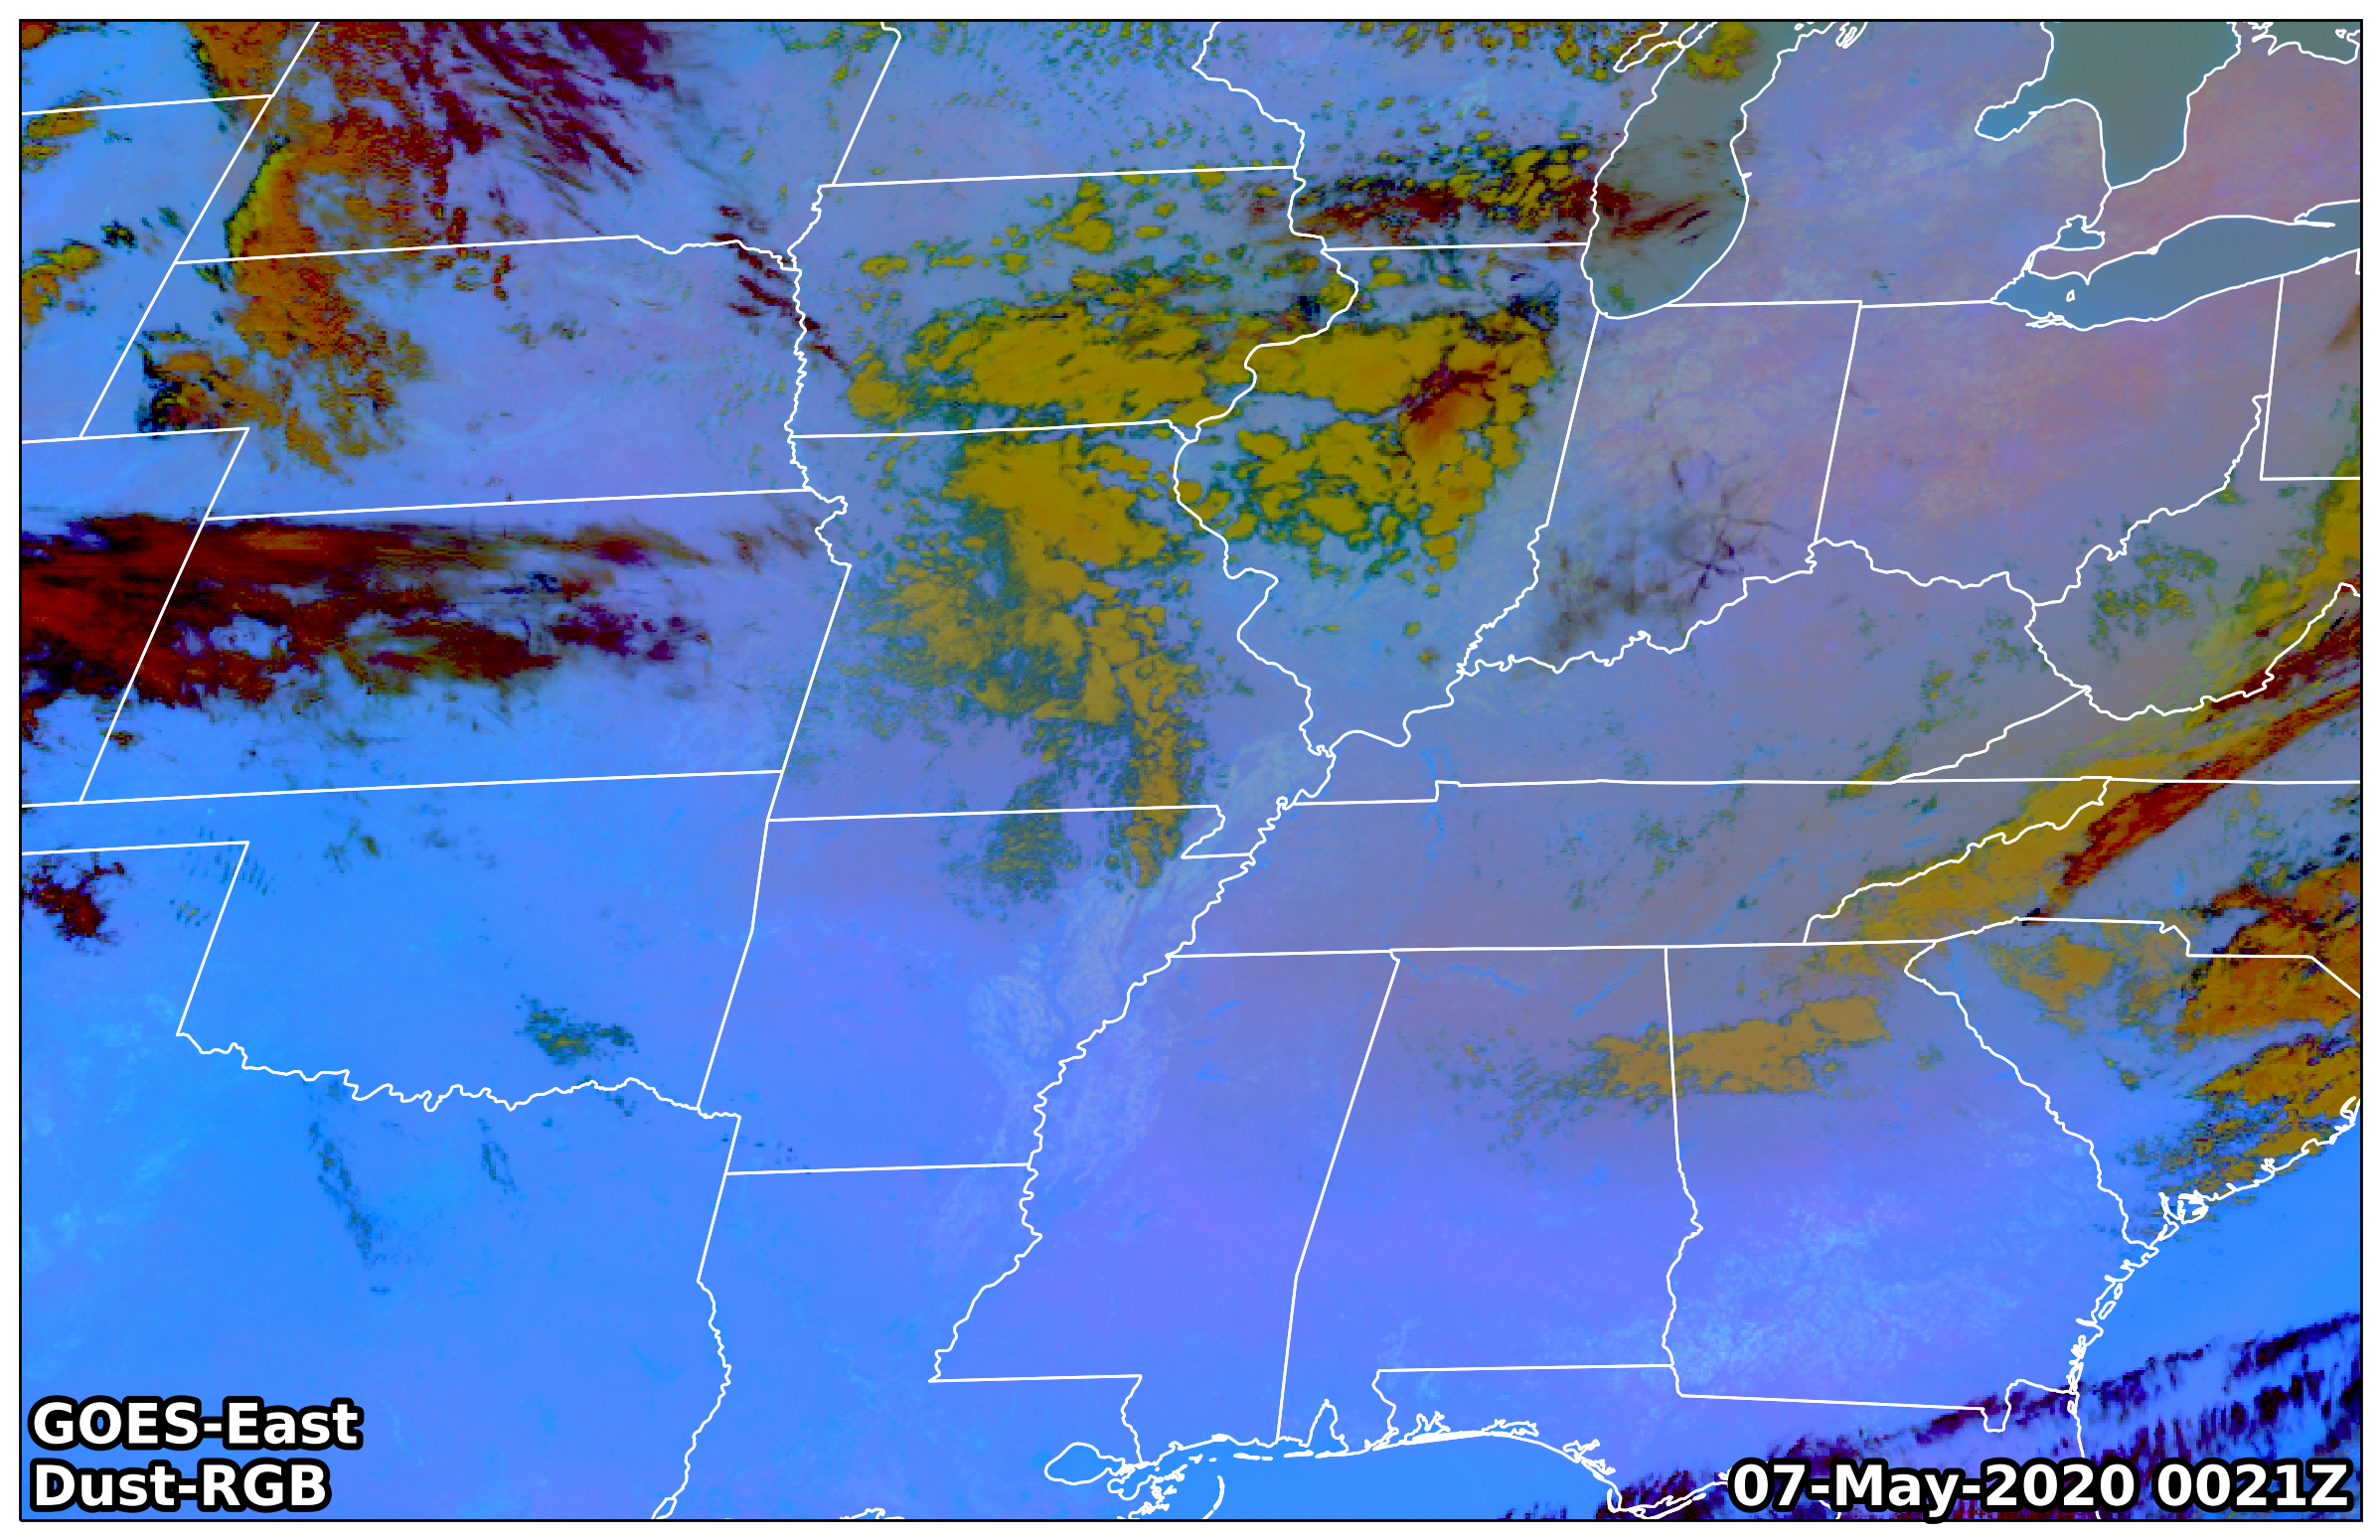

In [18]:
GOES_RGB(product,filenames,extent=[-100,-80,30,45])